In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
import pandas as pd
import glob
from scipy.stats import poisson
from scipy.stats import multivariate_normal
import pyccl as ccl
import math
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules')
import abundance as cl_count
import covariance as covar
import mvp_pdf
import edit

In [2]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

# Binned data

# Prediction

In [3]:
n_z_bin = 20
n_logm_bin = 30
z_corner = np.linspace(0.2, 1.2, n_z_bin + 1)
logm_corner = np.linspace(14.2, 15.6, n_logm_bin + 1)
Z_bin, logMass_bin = binning(z_corner), binning(logm_corner)

In [4]:
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef('vir', 'critical')
hmd = ccl.halos.hmfunc.MassFuncDespali16(mass_def=massdef)
halobias = ccl.halos.hbias.HaloBiasTinker10( mass_def= massdef, mass_def_strict=True)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25) * 4 * np.pi
clc.f_sky = clc.sky_area/(4*np.pi)
z_grid = np.linspace(0., 2.1, 2000)
logm_grid = np.linspace(14.1, 15.7, 2001)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')
clc.compute_halo_bias_grid_MZ(z_grid = z_corner, logm_grid = logm_corner, halobiais = halobias)
NHalo_bias = clc.Nhalo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')

In [5]:
Halo_bias =NHalo_bias/Abundance

In [6]:
Covariance = covar.Covariance_matrix()
#use PySSC from Lacasa et al.
Sij = Covariance.matter_fluctuation_amplitude_fullsky(Z_bin)

In [7]:
Sample_covariance = Covariance.sample_covariance_full_sky(Z_bin, logMass_bin,  Halo_bias, Sij)/clc.f_sky

top


In [8]:
Covariance_prediction = Sample_covariance + np.diag(Abundance.flatten())

In [9]:
mu_list = Abundance.flatten()
var_SSC_list = Sample_covariance.diagonal()

In [10]:
mu_list_order =mu_list

In [11]:
index = 1
mu = mu_list_order[index]
var_SSC= var_SSC_list[index]

In [12]:
var_SSC

0.0005867602719962303

In [13]:
mu

426.2769096913601

In [14]:
mu_list_order.shape

(600,)

In [15]:
def Poisson(n, mu):
    return np.exp(-(mu-n)**2/(2*(mu)))

In [16]:
n = np.arange(mu*2)

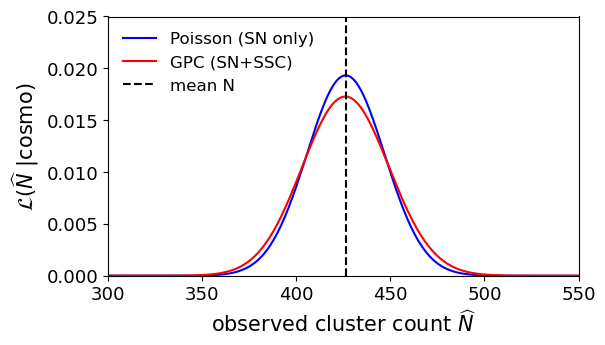

In [48]:
import matplotlib
#matplotlib.rcParams['mathtext.fontset'] = 'stix'
#matplotlib.rcParams['font.family'] = 'STIXGeneral'
y_poisson = [Poisson(n_, mu) for n_ in n]
x = np.linspace(-.8, .8, 100)
plt.figure(figsize=(6,3.5))
y_GPC = [np.trapz(Poisson(n_, mu*(1 + x))*np.exp(-(x)**2/(2*var_SSC))) for n_ in n]
plt.plot(n, y_poisson/(np.trapz(y_poisson, n)), '-b', label = 'Poisson (SN only)')
plt.plot(n, y_GPC/(np.trapz(y_GPC, n)), '-r', label = 'GPC (SN+SSC)')
plt.vlines(mu, 0, 10, label = 'mean N', color = 'k', ls='--')
plt.ylim(0, .025)
plt.xlim(300, 550)
plt.ylabel(r'$\mathcal{L}(\widehat{N}\ | \mathrm{cosmo})$', fontsize=15)
plt.xlabel(r'observed cluster count $\widehat{N}$', fontsize=15)
plt.legend(fontsize=12, frameon=False, loc = 'upper left')
plt.tight_layout()
plt.tick_params(axis='both', which = 'major', labelsize= 13)
plt.savefig('hmf.png', bbox_inches='tight', dpi=300)